In [1]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl

In [2]:
plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

In [3]:
def pos(x):
    for i in range(len(data[0])):
        if data[0,i]>=x:
            return i
            break

FitFunktionen

In [4]:
def gaus1fit(von,bis,path,yscale,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],weights=1/data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],yscale*data[1,vonarr:bisarr],yerr=yscale*data[2,vonarr:bisarr],fmt='o',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),yscale*out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())


    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]), out_gaus




def gaus2fit(von,bis,path,override=False,m1=1,s1=1,scale1=1,m2=1,s2=1,scale2=1,m1min=1,m1max=1,m2min=1,m2max=1): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")

    def guess(data,x):
        params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(data,x)
        params=model_gaus.make_params()
        for i in params_g1:
            params[i]=params_g1[i]
                    
        params["g2_center"].value=params.get("g1_center").value-1
        params["g2_sigma"].value=params.get("g1_sigma").value*0.5
        params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
        return params

    model_gaus.guess=guess
    pars_gaus = model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["g1_center"].set(value=m1,min=m1min,max=m1max)
        pars_gaus["g1_sigma"].set(value=s1)
        pars_gaus["g1_amplitude"].set(value=scale1)
        pars_gaus["g2_center"].set(value=m2,min=m2min,max=m2max)
        pars_gaus["g2_sigma"].set(value=s2)
        pars_gaus["g2_amplitude"].set(value=scale2)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],weights=1/data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],yscale*data[1,vonarr:bisarr],yerr=yscale*data[2,vonarr:bisarr],fmt='o',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),yscale*out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())

    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]), out_gaus

Daten einlesen und Standartfehler as Fehler der Counts festlegen

<ErrorbarContainer object of 3 artists>

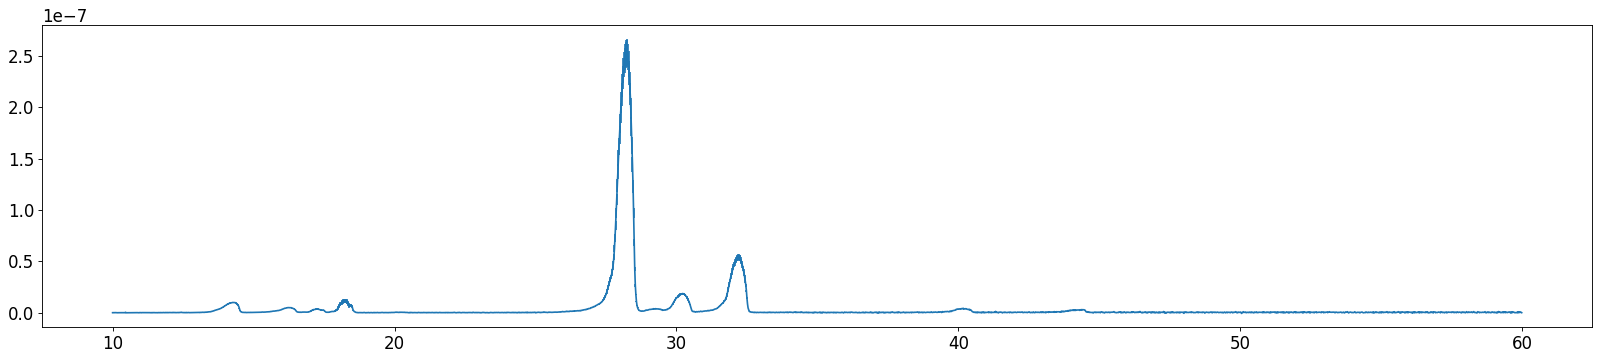

In [5]:
with open('Data/uluft_1.csv', mode='r') as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        data = np.zeros((3,len(dataex[3])))
        data[0],data[1] = dataex[3],dataex[4]

with open('Data/restgas_3.csv', mode='r') as tf:
        datarestex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        datarest = np.zeros((3,len(datarestex[3])))
        datarest[0],datarest[1] = datarestex[3],datarestex[4]




#data
err = list(np.zeros(len(data[1])))
for i in range(len(err)):
    err[i] = ufloat(data[1,i],float(abs(data[1,i])*0.05))

#est
errrest = list(np.zeros(len(datarest[1])))
for i in range(len(errrest)):
    errrest[i] = ufloat(datarest[1,i],float(abs(datarest[1,i])*0.05))

for i in range(len(err)):
        err[i] = err[i]-errrest[i]

for i in range(len(data[1])):
    err[i] = err[i]*data[0,i]/28

for i in range(len(err)):
    data[1,i]=err[i].n
    data[2,i]=err[i].s








v = pos(10)
b = pos(60)

fig = plt.figure(figsize=(25,5),dpi=80,linewidth=50)
plt.errorbar(data[0,v:b],data[1,v:b],yerr=data[2,v:b],label = 'Data')
#plt.vlines(18.6,0,10e-9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 42
    # variables        = 3
    chi-square         = 1494.98230
    reduced chi-square = 38.3328796
    Akaike info crit   = 156.032401
    Bayesian info crit = 161.245410
[[Variables]]
    amplitude:  5.3035e-09 +/- 2.7939e-10 (5.27%) (init = 7.88764e-09)
    center:     14.1308823 +/- 0.01120965 (0.08%) (init = 14.2)
    sigma:      0.20527828 +/- 0.00823627 (4.01%) (init = 0.28)
    fwhm:       0.48339341 +/- 0.01939493 (4.01%) == '2.3548200*sigma'
    height:     1.0307e-08 +/- 7.5244e-10 (7.30%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = -0.608
    C(amplitude, sigma) = -0.223


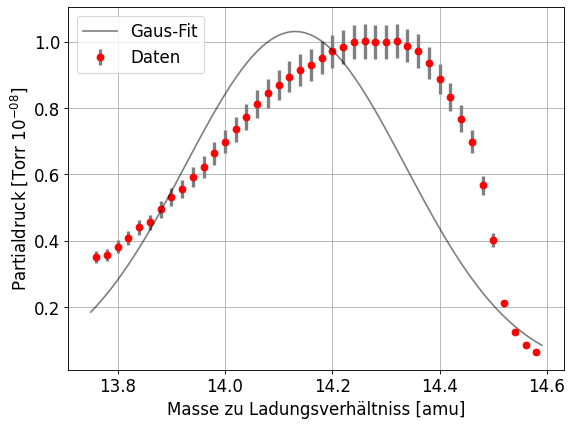

In [6]:
p14 = gaus1fit(13.75,14.6,'uluft_14.2',1e8)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 42
    # variables        = 3
    chi-square         = 382.213344
    reduced chi-square = 9.80034215
    Akaike info crit   = 98.7489917
    Bayesian info crit = 103.962001
[[Variables]]
    amplitude:  2.8558e-09 +/- 1.0321e-10 (3.61%) (init = 3.160039e-09)
    center:     16.1623933 +/- 0.00858670 (0.05%) (init = 16.22)
    sigma:      0.23809396 +/- 0.00923371 (3.88%) (init = 0.24)
    fwhm:       0.56066843 +/- 0.02174373 (3.88%) == '2.3548200*sigma'
    height:     4.7850e-09 +/- 2.6077e-10 (5.45%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.175
    C(amplitude, center) = 0.132


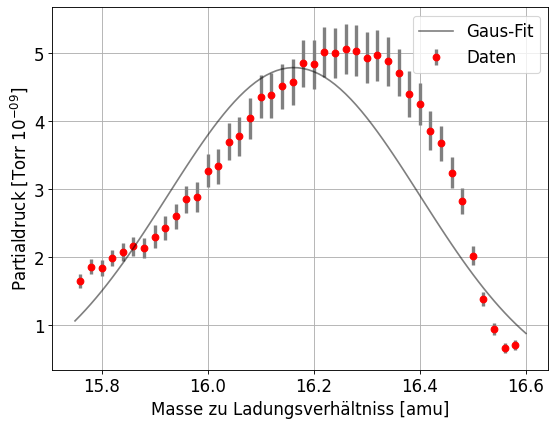

In [7]:
p16 = gaus1fit(15.75,16.6,'uluft_16.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 35
    # variables        = 3
    chi-square         = 22.9412576
    reduced chi-square = 0.71691430
    Akaike info crit   = -8.78438958
    Bayesian info crit = -4.11834540
[[Variables]]
    amplitude:  1.7370e-09 +/- 4.8284e-11 (2.78%) (init = 2.122982e-09)
    center:     17.2662852 +/- 0.00520265 (0.03%) (init = 17.28)
    sigma:      0.18367856 +/- 0.00533676 (2.91%) (init = 0.22)
    fwhm:       0.43252995 +/- 0.01256711 (2.91%) == '2.3548200*sigma'
    height:     3.7727e-09 +/- 1.4803e-10 (3.92%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = -0.173


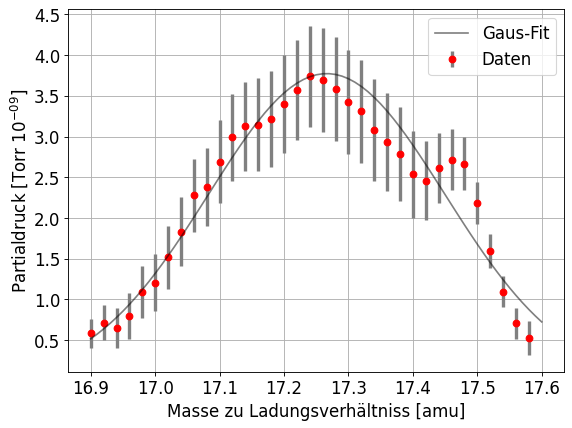

In [8]:
p17 = gaus1fit(16.9,17.6,'uluft_17.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 53
    # variables        = 3
    chi-square         = 362.372625
    reduced chi-square = 7.24745250
    Akaike info crit   = 107.886199
    Bayesian info crit = 113.797075
[[Variables]]
    amplitude:  5.4010e-09 +/- 4.4518e-10 (8.24%) (init = 7.895968e-09)
    center:     18.2192170 +/- 0.01006715 (0.06%) (init = 18.25)
    sigma:      0.15797596 +/- 0.00429480 (2.72%) (init = 0.23)
    fwhm:       0.37200496 +/- 0.01011347 (2.72%) == '2.3548200*sigma'
    height:     1.3639e-08 +/- 1.2554e-09 (9.20%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.853
    C(amplitude, center) = -0.268
    C(amplitude, sigma)  = -0.209


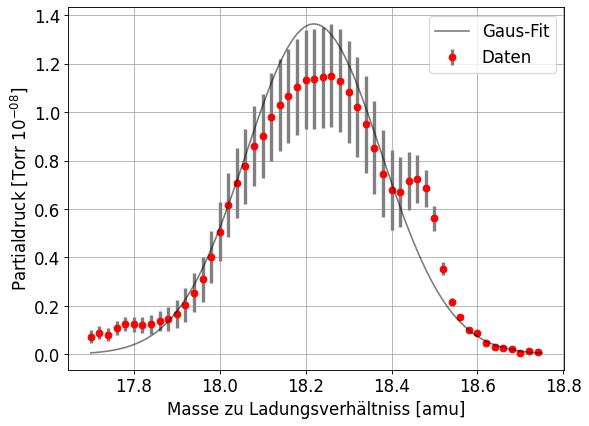

In [9]:
p18 = gaus1fit(17.7,18.75,'uluft_18.2',1e8)#,override=False,m1=18.21,m1min=18,m1max=18.5,s1=0.23,scale1=2.533068e-08,m2=17.21,m2min=17,m2max=17.5,s2=0.9,scale2=7.599203e-09)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 58
    # variables        = 3
    chi-square         = 2594.89316
    reduced chi-square = 47.1798756
    Akaike info crit   = 226.449742
    Bayesian info crit = 232.631071
[[Variables]]
    amplitude:  1.2285e-07 +/- 7.3988e-09 (6.02%) (init = 1.964938e-07)
    center:     28.1045382 +/- 0.00758084 (0.03%) (init = 28.18)
    sigma:      0.19170776 +/- 0.00402476 (2.10%) (init = 0.26)
    fwhm:       0.45143726 +/- 0.00947758 (2.10%) == '2.3548200*sigma'
    height:     2.5565e-07 +/- 1.8993e-08 (7.43%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.707
    C(amplitude, sigma)  = -0.574
    C(amplitude, center) = 0.291


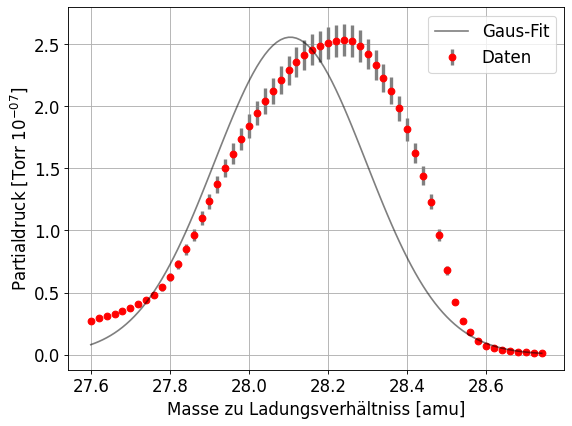

In [10]:
p28 = gaus1fit(27.6,28.75,'uluft_28.2',1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 35
    # variables        = 3
    chi-square         = 25.8234618
    reduced chi-square = 0.80698318
    Akaike info crit   = -4.64226141
    Bayesian info crit = 0.02378277
[[Variables]]
    amplitude:  3.1844e-09 +/- 6.2502e-11 (1.96%) (init = 1.644668e-09)
    center:     29.2547591 +/- 0.00681705 (0.02%) (init = 29.25)
    sigma:      0.33631308 +/- 0.00792719 (2.36%) (init = 0.23)
    fwhm:       0.79195678 +/- 0.01866710 (2.36%) == '2.3548200*sigma'
    height:     3.7774e-09 +/- 4.0426e-11 (1.07%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.893
    C(amplitude, center) = 0.837
    C(center, sigma)     = 0.782


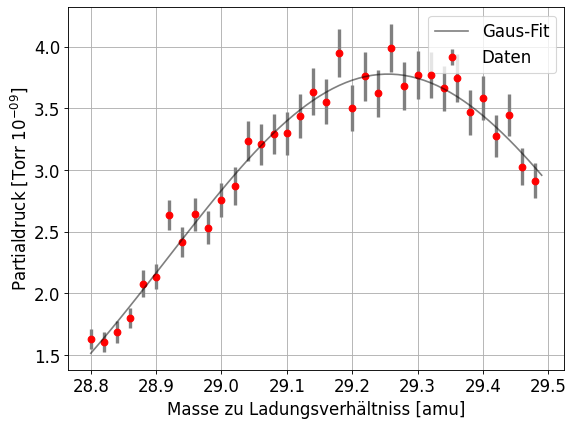

In [11]:
p29 = gaus1fit(28.8,29.5,'uluft_29.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 50
    # variables        = 3
    chi-square         = 1354.02603
    reduced chi-square = 28.8090644
    Akaike info crit   = 170.940733
    Bayesian info crit = 176.676802
[[Variables]]
    amplitude:  1.0174e-08 +/- 4.4221e-10 (4.35%) (init = 1.410767e-08)
    center:     30.1125187 +/- 0.00695195 (0.02%) (init = 30.17)
    sigma:      0.22096356 +/- 0.00574104 (2.60%) (init = 0.27)
    fwhm:       0.52032942 +/- 0.01351912 (2.60%) == '2.3548200*sigma'
    height:     1.8369e-08 +/- 1.0875e-09 (5.92%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.417
    C(center, sigma)     = -0.229
    C(amplitude, center) = 0.175


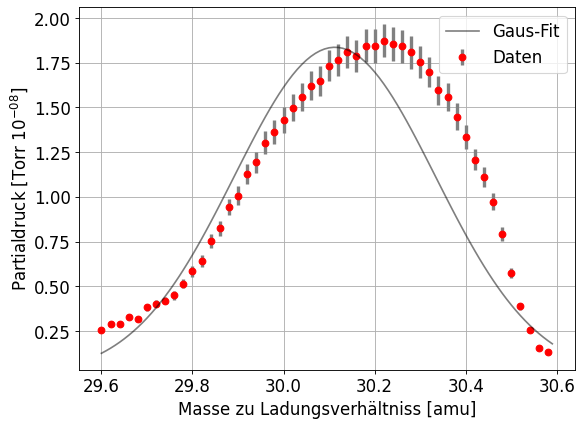

In [12]:
p30 = gaus1fit(29.6,30.6,'uluft_30.2',1e8)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 60
    # variables        = 3
    chi-square         = 3964.01733
    reduced chi-square = 69.5441637
    Akaike info crit   = 257.440122
    Bayesian info crit = 263.723156
[[Variables]]
    amplitude:  2.6604e-08 +/- 1.9453e-09 (7.31%) (init = 4.52243e-08)
    center:     32.0680272 +/- 0.01075419 (0.03%) (init = 32.16)
    sigma:      0.20082633 +/- 0.00528717 (2.63%) (init = 0.28)
    fwhm:       0.47290987 +/- 0.01245034 (2.63%) == '2.3548200*sigma'
    height:     5.2848e-08 +/- 4.7876e-09 (9.06%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.810
    C(amplitude, sigma)  = -0.563
    C(amplitude, center) = 0.281


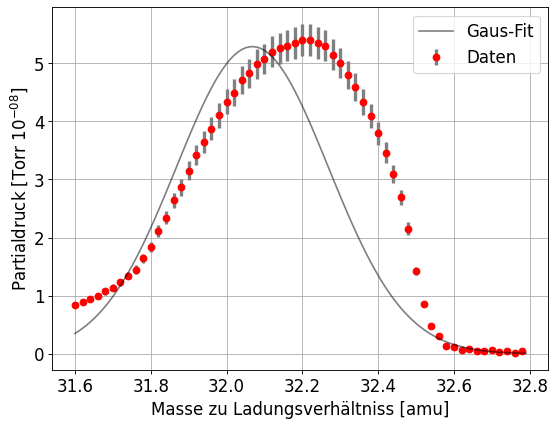

In [13]:
p32 = gaus1fit(31.6,32.8,'uluft_32.2',1e8)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 55
    # variables        = 3
    chi-square         = 2363.98979
    reduced chi-square = 45.4613421
    Akaike info crit   = 212.842508
    Bayesian info crit = 218.864508
[[Variables]]
    amplitude:  2.4709e-09 +/- 1.1898e-10 (4.82%) (init = 3.419452e-09)
    center:     40.0572300 +/- 0.01035795 (0.03%) (init = 40.15)
    sigma:      0.26503169 +/- 0.00973235 (3.67%) (init = 0.29)
    fwhm:       0.62410192 +/- 0.02291793 (3.67%) == '2.3548200*sigma'
    height:     3.7194e-09 +/- 2.6222e-10 (7.05%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.369
    C(center, sigma)     = -0.305
    C(amplitude, center) = 0.196


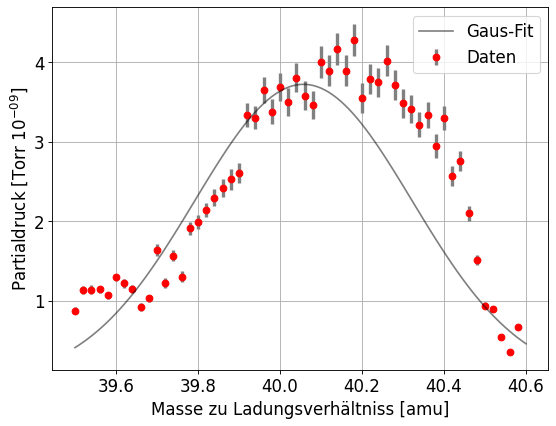

In [14]:
p40 = gaus1fit(39.5,40.6,'uluft_40.2',1e9)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 63
    # variables        = 3
    chi-square         = 1791.76777
    reduced chi-square = 29.8627962
    Akaike info crit   = 216.912866
    Bayesian info crit = 223.342270
[[Variables]]
    amplitude:  1.9785e-09 +/- 1.1038e-10 (5.58%) (init = 2.948646e-09)
    center:     44.0590988 +/- 0.01520550 (0.03%) (init = 44.17636)
    sigma:      0.32342425 +/- 0.01617360 (5.00%) (init = 0.35)
    fwhm:       0.76160589 +/- 0.03808593 (5.00%) == '2.3548200*sigma'
    height:     2.4405e-09 +/- 2.1785e-10 (8.93%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = -0.509
    C(amplitude, sigma) = -0.422


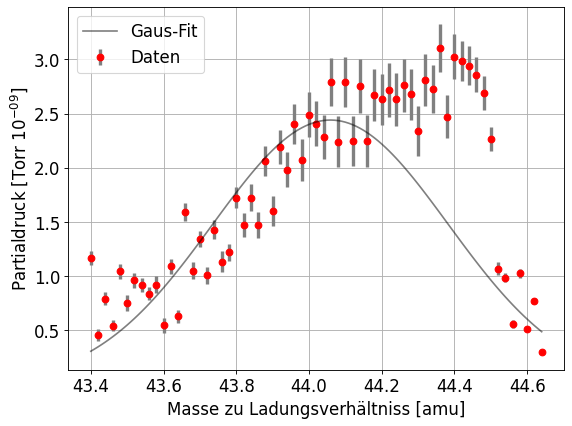

In [15]:
p44 = gaus1fit(43.4,44.65,'uluft_44.2',1e9)

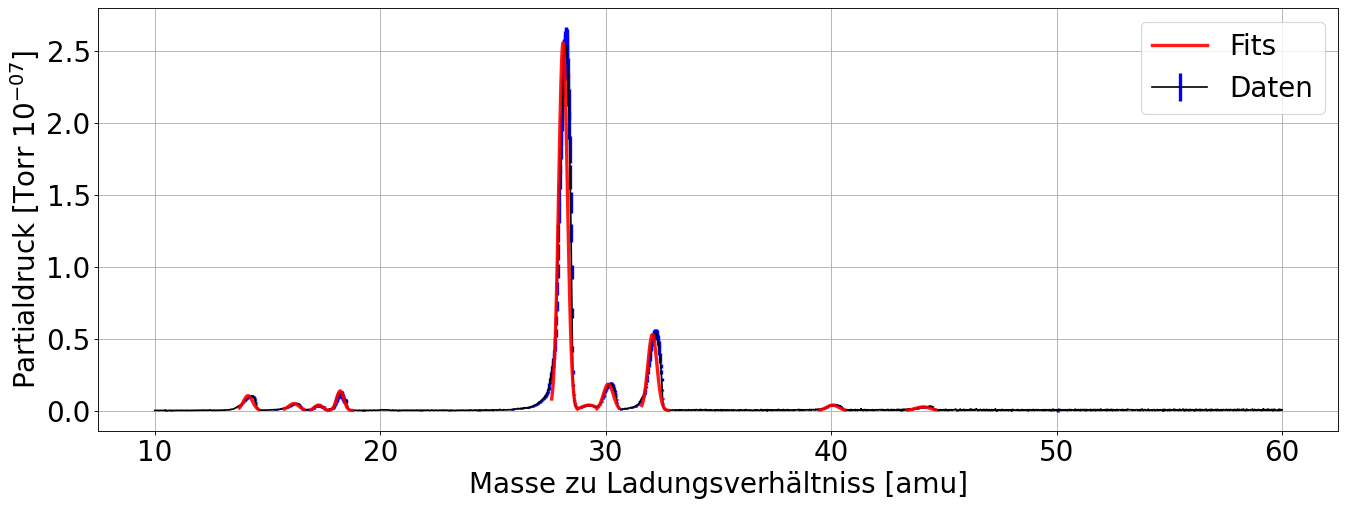

In [16]:
fig = plt.figure(figsize=(20,7),dpi=80,linewidth=50)
yscale = 1e7
plt.rc ('font', size =25) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 25) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 25) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 25) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 25) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 25) #Schriftgröße der Legende


plt.errorbar(data[0],yscale*data[1],yerr=yscale*data[2],zorder=5,mfc='black',color='k',linestyle='-',label='Daten',ecolor='b',elinewidth=3)

plt.plot(p14[0][0],yscale*p14[0][1],zorder=10,color='r',alpha=0.9,linewidth=3,label='Fits')
plt.plot(p16[0][0],yscale*p16[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p17[0][0],yscale*p17[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p18[0][0],yscale*p18[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p28[0][0],yscale*p28[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p29[0][0],yscale*p29[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p30[0][0],yscale*p30[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p32[0][0],yscale*p32[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p40[0][0],yscale*p40[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p44[0][0],yscale*p44[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)


plt.xlabel('Masse zu Ladungsverhältniss [amu]')
plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
plt.grid()

plt.legend()
plt.savefig("Results/ges_speck_uluft.pdf")

In [17]:
print(p14[1].fit_report())
print(p16[1].fit_report())
print(p17[1].fit_report())
print(p18[1].fit_report())
print(p28[1].fit_report())
print(p29[1].fit_report())
print(p30[1].fit_report())
print(p32[1].fit_report())
print(p40[1].fit_report())
print(p44[1].fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 42
    # variables        = 3
    chi-square         = 1494.98230
    reduced chi-square = 38.3328796
    Akaike info crit   = 156.032401
    Bayesian info crit = 161.245410
[[Variables]]
    amplitude:  5.3035e-09 +/- 2.7939e-10 (5.27%) (init = 7.88764e-09)
    center:     14.1308823 +/- 0.01120965 (0.08%) (init = 14.2)
    sigma:      0.20527828 +/- 0.00823627 (4.01%) (init = 0.28)
    fwhm:       0.48339341 +/- 0.01939493 (4.01%) == '2.3548200*sigma'
    height:     1.0307e-08 +/- 7.5244e-10 (7.30%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)    = -0.608
    C(amplitude, sigma) = -0.223
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 42
    # variables        = 3
    chi-square         = 382

In [18]:

amp14 = ufloat(p14[1].params['amplitude'].value,p14[1].params['amplitude'].stderr)
amp16 = ufloat(p16[1].params['amplitude'].value,p16[1].params['amplitude'].stderr)
amp17 = ufloat(p17[1].params['amplitude'].value,p17[1].params['amplitude'].stderr)
amp18 = ufloat(p18[1].params['amplitude'].value,p18[1].params['amplitude'].stderr)
amp28 = ufloat(p28[1].params['amplitude'].value,p28[1].params['amplitude'].stderr)
amp29 = ufloat(p29[1].params['amplitude'].value,p29[1].params['amplitude'].stderr)
amp30 = ufloat(p30[1].params['amplitude'].value,p30[1].params['amplitude'].stderr)
amp32 = ufloat(p32[1].params['amplitude'].value,p32[1].params['amplitude'].stderr)
amp40 = ufloat(p40[1].params['amplitude'].value,p40[1].params['amplitude'].stderr)
amp44 = ufloat(p44[1].params['amplitude'].value,p44[1].params['amplitude'].stderr)


print('Poesitionm m/z')
print(ufloat(p14[1].params['center'].value,p14[1].params['center'].stderr))
print(ufloat(p16[1].params['center'].value,p16[1].params['center'].stderr))
print(ufloat(p17[1].params['center'].value,p17[1].params['center'].stderr))
print(ufloat(p18[1].params['center'].value,p18[1].params['center'].stderr))
print(ufloat(p28[1].params['center'].value,p28[1].params['center'].stderr))
print(ufloat(p29[1].params['center'].value,p29[1].params['center'].stderr))
print(ufloat(p30[1].params['center'].value,p30[1].params['center'].stderr))
print(ufloat(p32[1].params['center'].value,p32[1].params['center'].stderr))
print(ufloat(p40[1].params['center'].value,p40[1].params['center'].stderr))
print(ufloat(p44[1].params['center'].value,p44[1].params['center'].stderr))



print('Amlitudes')

print(amp14)
print(amp16)
print(amp17)
print(amp18)
print(amp28)
print(amp29)
print(amp30)
print(amp32)
print(amp40)
print(amp44)


print('unkorr amplitude summe hauptpeaks')
print(amp16+amp17+amp18+amp28+amp32+amp40+amp44)


print('Reihenfolge')
print('Methan')
print('Ammoniak')
print('Wasser')
print('Stickstoff')
print('Sauerstoff')
print('Argon')
print('CO2')



print('Gesamtamplitude')
amp16 = amp16*2.14/1.6
amp17 = amp17*1.9/1.3
amp18 = amp18*1.25/0.9
amp28 = amp28*1.8/1
amp32 = amp32*1.11/0.86
amp40 = amp40*1.11/1.2
amp44 = amp44*1.38/1.4


print(amp16)
print(amp17)
print(amp18)
print(amp28)
print(amp32)
print(amp40)
print(amp44)


sum=amp16+amp17+amp18+amp28+amp32+amp40+amp44


print('Gesamtdruck')
print(sum)


print('Gesamtdruck speck aufaddiert')
sumgs = 0
for i in range(len(data[1])):
    sumgs += ufloat(data[1,i],data[2,i])
print(sumgs)



print('Gesamtdruck/Gesamtamplituden')
print(amp16/sum)
print(amp17/sum)
print(amp18/sum)
print(amp28/sum)
print(amp32/sum)
print(amp40/sum)
print(amp44/sum)



Poesitionm m/z
14.131+/-0.011
16.162+/-0.009
17.266+/-0.005
18.219+/-0.010
28.105+/-0.008
29.255+/-0.007
30.113+/-0.007
32.068+/-0.011
40.057+/-0.010
44.059+/-0.015
Amlitudes
(5.30+/-0.28)e-09
(2.86+/-0.10)e-09
(1.74+/-0.05)e-09
(5.4+/-0.4)e-09
(1.23+/-0.07)e-07
(3.18+/-0.06)e-09
(1.02+/-0.04)e-08
(2.66+/-0.19)e-08
(2.47+/-0.12)e-09
(1.98+/-0.11)e-09
unkorr amplitude summe hauptpeaks
(1.64+/-0.08)e-07
Reihenfolge
Methan
Ammoniak
Wasser
Stickstoff
Sauerstoff
Argon
CO2
Gesamtamplitude
(3.82+/-0.14)e-09
(2.54+/-0.07)e-09
(7.5+/-0.6)e-09
(2.21+/-0.13)e-07
(3.43+/-0.25)e-08
(2.29+/-0.11)e-09
(1.95+/-0.11)e-09
Gesamtdruck
(2.74+/-0.14)e-07
Gesamtdruck speck aufaddiert
(1.157+/-0.006)e-05
Gesamtdruck/Gesamtamplituden
0.0140+/-0.0009
0.0093+/-0.0005
0.0274+/-0.0026
0.808+/-0.012
0.126+/-0.010
0.0084+/-0.0006
0.0071+/-0.0005
